In [1]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using ProfileVega
using Random
using Statistics

# The default format SVG creates figures of size 9600x6400
ProfileVega.set_default_size(1200, 800)

Random.seed!(42)

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [2]:
using Revise

#### Code

In [3]:
module RaceTrack2d

import ReinforcementLearningSutton: actions, finished, restart, update
using ReinforcementLearningSutton: GameGridWorldBase, GameGridWorld, I2, T2, I4, T4, dims, index, nstates, state, state_set, states, value

pos(t::T4) = t[1:2]
speed(t::T4) = t[3:4]
pos(i::I4) = pos(value(i))
speed(i::I4) = speed(value(i))

"Find all cells crossed by the next movement and check if at least one of them is a goal"
function _path_intersects_goals(pos::T2, speed::T2, goals::Vector{T2})
    if speed[2] == 0
        length(intersect([pos .+ (i, 0) for i in 1:speed[1]], goals)) > 0
    elseif speed[1] == 0
        length(intersect([pos .+ (0, i) for i in 1:speed[2]], goals)) > 0
    else
        length(intersect([pos .+ (x, y) for x in 0:speed[1] for y in 0:speed[2]
                          if (2y + 1) / (2x - 1) > pos[2] / pos[1] > (2y - 1) / (2x + 1)],
                         goals)) > 0
    end
end

"Find out next state and check if it will be outside the track (and not through the goal)"
function _path_will_kill_you(state::I4, track::Array{Int, 2}, is_goal::Bool)
    pf = pos(state) .+ speed(state)
    ~is_goal && ((pf[1] < 1) || (pf[2] < 1) || (pf[1] > size(track)[1]) || (pf[2] > size(track)[2]) || (track[pf...] == 0))
end

"Get all actions available for a given state, and index them from 1 to n"
function _state_actions(state::I4, all_actions::Vector{I2})
    map(
        ((i, a), ) -> I2(value(a), i),
        enumerate(
            filter(
                a -> begin
                    vf = speed(state) .+ value(a)
                    (0 <= vf[1] < 5) && (-5 < vf[2] <= 0) && (vf[1] != 0 || vf[2] != 0)
                    end,
                all_actions
            )
        )
    )
end

struct RulesetBase
    states_start::Vector{I4}
    state_is_goal::Vector{Bool}
    state_is_death::Vector{Bool}
    states_actions::Vector{Vector{I2}}
    
    prob_no_action::Float64
    
    function RulesetBase(game0::GameGridWorldBase, track::Array{Int, 2}, prob_no_action::Float64 = 0.0)
        cells_start = [Tuple(idx) for idx in CartesianIndices(track) if track[idx] == 2]
        cells_goal = [Tuple(idx) for idx in CartesianIndices(track) if track[idx] == 3]
        states_start = map(p -> state(game0, (p..., 0, 0)), cells_start)

        state_is_goal = map(s -> _path_intersects_goals(pos(s), speed(s), cells_goal), states(game0))
        state_is_death = map((s, is_goal) -> _path_will_kill_you(s, track, is_goal), states(game0), state_is_goal)
        states_actions =  map(s -> _state_actions(s, game0.actions), states(game0))
        
        new(states_start, state_is_goal, state_is_death, states_actions, prob_no_action)
    end
end

const GameType = GameGridWorld{GameGridWorldBase{T4, T2}, RulesetBase}

function actions(game::GameType, state::I4)
    game.ruleset.states_actions[index(state)]
end

finished(game::GameType) = game.ruleset.state_is_goal[index(state(game))]
restart(game::GameType) = state_set(game, rand(game.ruleset.states_start))

function update(game::GameType, action::I2)::Int

    if (game.ruleset.prob_no_action > 0) & (rand() < game.ruleset.prob_no_action)
        action = I2((0, 0), 1)  # Index is not important
    end

    # Update speed to check if the movement is a winner/loser one
    state_i = state(game)
    speed_f = speed(state_i) .+ value(action)
    state_f = state(game, (pos(state_i)..., speed_f...))

    if game.ruleset.state_is_goal[index(state_f)]
        ;
    elseif game.ruleset.state_is_death[index(state_f)]
        restart(game)
    else
        state_f = state(game, value(state_f) .+ (speed_f..., 0, 0))
        state_set(game, state_f)
    end
    
    -1
end

end;

#### Game used for tests

In [4]:
using ReinforcementLearningSutton: GameGridWorldBase, GameGridWorld, play_game

track = permutedims(
    [
    0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3
    0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
    0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
    0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
    1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
    1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
    1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
    0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0
    ],
    [2, 1])

dims = (size(track)..., 5, 5)
allowed_movements = [(1, 0), (0, 1), (-1, 0), (0, -1)]
pos0 = (1, 1, 0, -4)

game0 = GameGridWorldBase(dims, allowed_movements, pos0)
ruleset = RaceTrack2d.RulesetBase(game0, track)
game = GameGridWorld(game0, ruleset);

#### Random policy

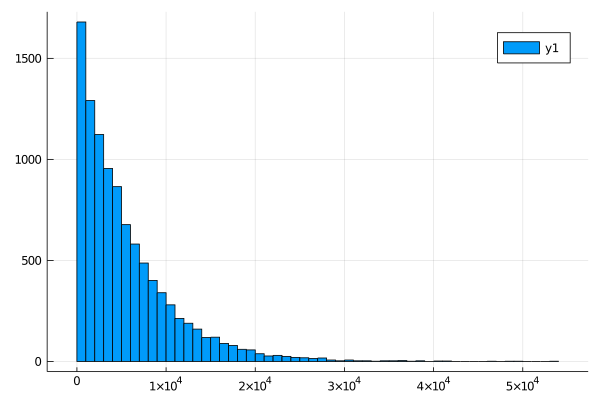

In [5]:
using ReinforcementLearningSutton: PlayerRandom

player = PlayerRandom(game)
max_nsteps = 100000
histogram([play_game(game, player, max_nsteps, nothing)[1] for _ in 1:10000])

#### Off-policy Monte Carlo optimization

In [6]:
using ReinforcementLearningSutton: LearningMonteCarloOffPolicy

player_on_policy = PlayerRandom(game)

for Γ in [0.5, 0.9, 1.0]
    for max_n_iter in [10, 100, 1000, 10000]
        learning = LearningMonteCarloOffPolicy(player_on_policy, max_nsteps, Γ, -500.)
        [play_game(game, player_on_policy, max_nsteps, learning) for _ in 1:max_n_iter]

        println("Γ: ", Γ, ", optimization iterations: ", max_n_iter)
        println("Average episode length: ", mean([play_game(game, learning.player_off_policy)[1] for _ in 1:100000]))
    end
end

Γ: 0.5, optimization iterations: 10
Average episode length: 17.34058
Γ: 0.5, optimization iterations: 100
Average episode length: 13.40823
Γ: 0.5, optimization iterations: 1000
Average episode length: 12.19733
Γ: 0.5, optimization iterations: 10000
Average episode length: 12.20001
Γ: 0.9, optimization iterations: 10
Average episode length: 16.60245
Γ: 0.9, optimization iterations: 100
Average episode length: 13.19938
Γ: 0.9, optimization iterations: 1000
Average episode length: 12.33414
Γ: 0.9, optimization iterations: 10000
Average episode length: 12.20083
Γ: 1.0, optimization iterations: 10
Average episode length: 15.98221
Γ: 1.0, optimization iterations: 100
Average episode length: 12.80429
Γ: 1.0, optimization iterations: 1000
Average episode length: 12.20077
Γ: 1.0, optimization iterations: 10000
Average episode length: 12.19946
